In [48]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Overview of Dataset

Image brain_tumor_data/no\33 no.jpg has shape: (213, 236, 3)
Image brain_tumor_data/no\20 no.jpg has shape: (259, 194, 3)
Image brain_tumor_data/no\N6.jpg has shape: (257, 196, 3)
Image brain_tumor_data/no\N5.jpg has shape: (250, 201, 3)
Image brain_tumor_data/no\40 no.jpg has shape: (225, 225, 3)
Image brain_tumor_data/yes\Y28.jpg has shape: (630, 630, 3)
Image brain_tumor_data/yes\Y104.jpg has shape: (890, 700, 3)
Image brain_tumor_data/yes\Y194.jpg has shape: (256, 256, 3)
Image brain_tumor_data/yes\Y92.jpg has shape: (260, 194, 3)
Image brain_tumor_data/yes\Y154.jpg has shape: (431, 400, 3)


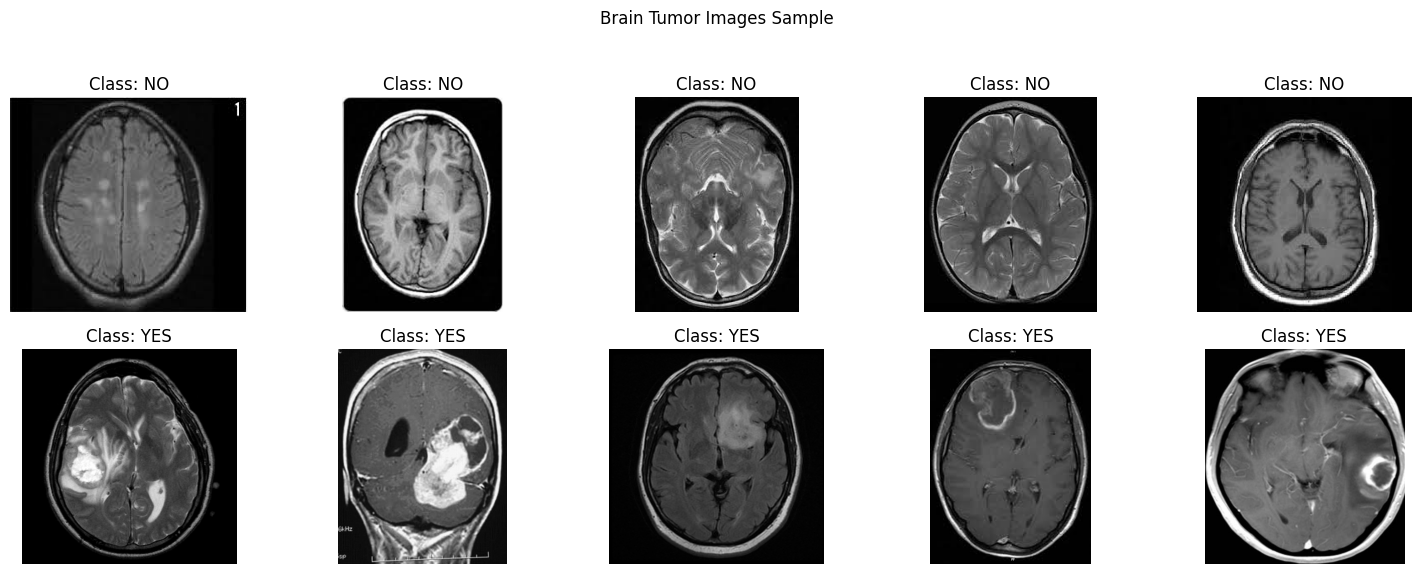

In [33]:
from PIL import Image

num_images = 5
root_dir = 'brain_tumor_data/'
# Set up the plot
fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15, 6))
fig.suptitle('Brain Tumor Images Sample')

# Class labels from subdirectory names
classes = ['no', 'yes']  # Adjust class names if different

for row, class_name in enumerate(classes):
    # Path to the class directory
    class_dir = os.path.join(root_dir, class_name)
    
    # Get all image files in the directory
    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg'))]
    
    # Shuffle the list to display random images each time
    np.random.shuffle(images)
    
    # Select the first num_images images
    selected_images = images[:num_images]
    
    for col, img_path in enumerate(selected_images):
        img = Image.open(img_path)

        img_array = np.array(img)  # Convert image to array
        print(f"Image {img_path} has shape: {img_array.shape}")
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Class: {class_name.upper()}")
        axes[row, col].axis('off')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Image Preprocessing and Splitting

Since the images are all of different sizes, we rescale them to feed to our model. 

The `ImageDataGenerator` class in Keras is a fantastic utility that helps you automatically generate batches of tensor image data with real-time data augmentation. This process can help prevent overfitting and make the model more robust to slight variations in inputs. Here's a breakdown of each property used in your `ImageDataGenerator`:

1. **`rescale=1./255`**:
   - This is a normalization step. It scales the pixel values in the image to the range 0-1 by dividing each pixel by 255. Traditionally, image pixel values are integers in the range 0-255. Normalizing these values to 0-1 helps the neural network converge faster during training.

2. **`shear_range=0.2`**:
   - Shear mapping or shearing transforms the image in such a way that it converts rectangles into parallelograms. The value `0.2` indicates the intensity of the shear in counter-clockwise direction. It's a way to apply random transversal transformations to the images in your dataset, which can help the model generalize better over different orientations of objects in the images.

3. **`zoom_range=0.2`**:
   - This parameter randomly zooms inside the pictures during preprocessing. The value `0.2` means that the image can be randomly zoomed in or out by up to 20%. This variation allows the model to learn to recognize objects in the image better, regardless of slight differences in size or perspective.

4. **`horizontal_flip=True`**:
   - This property randomly flips inputs horizontally. This is particularly useful for training on images where horizontal flips do not change the overall understanding or classification of the image (like a cat being a cat, whether it faces left or right). It effectively increases the size of your training dataset and helps the model generalize better across horizontally flipped images.

5. **`validation_split=0.3`**:
   - This property is used to reserve a portion of your training data for validation. The value `0.3` signifies that 30% of the data would be set aside for validation purposes. This means that this portion of the data will not be used for training the model but only to evaluate its performance. This helps in tuning the hyperparameters of the model better without overfitting the training dataset.

These settings in the `ImageDataGenerator` provide a robust way to augment your dataset, helping to prevent overfitting and improving the generalization of your model. This kind of data augmentation is especially powerful in deep learning applications involving images, where the model's ability to adapt to variations in unseen data is crucial for good performance.

The code you've shared sets up an `ImageDataGenerator` to generate batches of image data for model validation using real-time data augmentation. Here's a detailed explanation of the `validation_generator` and how it works with the `ImageDataGenerator` you've configured:

### Key Components of the `validation_generator`

1. **`flow_from_directory` Method**:
   - This method creates a generator that reads images from a directory (and its subdirectories) on disk, using the augmentation parameters defined in the `ImageDataGenerator`. It automatically labels the images based on the subdirectory names, which should correspond to class labels (e.g., 'yes' and 'no' for a binary classification task).

2. **`'brain_tumor_data/'`**:
   - This is the directory from which the images are loaded. It assumes that this directory contains subdirectories, each named after one of your classes (e.g., a 'yes' folder for positive cases and a 'no' folder for negative cases). The images for training and validation will be pulled from these subdirectories.

3. **`target_size=(224, 224)`**:
   - This specifies the dimensions to which all images found will be resized. In this case, each image will be resized to 224x224 pixels. This resizing is crucial because it ensures that all images fed into your model are of the same size, which is a requirement for CNNs.

4. **`batch_size=32`**:
   - This sets the number of images to process at a time. Here, 32 images will be loaded and augmented at once and then passed through the network. Batch size can affect training speed, memory usage, and sometimes model performance.

5. **`class_mode='binary'`**:
   - This indicates that the labels are expected to be binary labels, 1 or 0 (yes or no). This parameter should match the output of your model (e.g., using a sigmoid activation function at the output layer for binary classification).

6. **`subset='validation'`**:
   - Since the `ImageDataGenerator` was set up with a `validation_split=0.3`, this parameter tells the generator to use the reserved 30% of the images for validation. This subset must not overlap with the training data.

7. **`shuffle=True`**:
   - This ensures that the batches generated are shuffled, meaning that the model will see the images in a different order at each epoch. Shuffling is important for training phases to prevent the model from learning anything from the order of the images, but it is also useful in validation to ensure randomness in the evaluated batches.

### How It Works Together
- When you fit your model or evaluate it using this `validation_generator`, it will generate batches of images that are randomly augmented according to the defined parameters (like shearing, zooming, and flipping). This helps the model generalize better and gives you a more reliable estimate of how well your model is likely to perform on unseen, real-world data.

- It’s important to note that the `flow_from_directory` function automatically infers the classes from the subdirectory names of the provided directory. Ensure that the structure of the directory and the contents are correctly set up to match this expectation.

By setting up this generator, you're ensuring that your validation data undergoes the same preprocessing and augmentation as your training data, which is crucial for maintaining consistency in how the data is handled and presented to the model. This setup helps avoid a common issue where differences in how data is preprocessed can lead to misleading validation results.

The **batch size** is a crucial hyperparameter in the training of machine learning models, particularly in the context of neural networks. Here’s an overview of what it does and why it's important:

### Definition
**Batch size** refers to the number of training examples utilized to train a single iteration in one step of the model training process in machine learning algorithms. In the context of deep learning and stochastic gradient descent (SGD), it's the number of samples over which the gradient is computed before updating the weights.

### Impact and Function
1. **Memory Efficiency**: Large datasets cannot be loaded entirely into memory. By dividing the dataset into manageable batches, it allows for efficient use of memory while training the model.

2. **Training Speed**:
   - **Smaller batches** provide a more frequent update of the model’s weights, potentially leading to faster convergence albeit possibly to a local minimum rather than the global minimum.
   - **Larger batches** provide a more accurate estimate of the gradient, but each update is computationally more expensive and requires more memory. This might result in a smoother convergence process.

3. **Generalization**:
   - Training with a smaller batch size generally provides a regularization effect and less stable convergence, potentially leading to better generalization in some cases. This instability comes from the noise in the gradient estimates, which can help escape local minima.
   - Larger batch sizes tend to have a more stable but deterministic path towards convergence, which might lead them to sharp minima that generalize less effectively on new data.

4. **Convergence Quality**:
   - **Smaller batch sizes** (including a batch size of 1, known as online learning) can lead to a convergence path that bounces around the optimum, sometimes finding new and potentially better paths.
   - **Larger batch sizes** tend to provide a smoother descent towards a minimum but can become stuck in suboptimal sharp minima.

### Practical Considerations
- **Noise vs. Stability**: Smaller batch sizes introduce noise into the learning process, which can be beneficial for avoiding local minima but can make training progression unstable. Larger batches reduce this noise, leading to more stable, but potentially less diverse exploration of weight configurations.
- **Hardware Constraints**: The choice of batch size can often be limited by the hardware available, particularly GPU memory limits. Larger batches require more memory, and maximizing batch size within the memory constraints of the system can often result in faster training per epoch.
- **Batch Size and Learning Rate**: The choice of batch size often affects the choice of learning rate. Smaller batch sizes often require a smaller learning rate because of the higher variance in gradient estimates.

### Optimal Batch Size
Choosing the optimal batch size is a trade-off based on the specific characteristics of the training data, the computational resources available, and the desired convergence characteristics. Experimentation and tuning are often required to find the best batch size for a particular scenario. Some modern training approaches use techniques like learning rate warm-up and adaptive learning rate schedules to help larger batches converge more effectively.

In summary, the batch size is a key parameter in the configuration of neural network training processes, affecting everything from computational efficiency to model performance and generalization.

In [59]:
# Create an ImageDataGenerator for training with data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # Set the validation split to 30% of the data
)

# # Create an ImageDataGenerator for testing, only rescaling
# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'brain_tumor_data/',  # This is the source directory for training images
    target_size=(224, 224),  # All images will be resized to 224x224 VGG16 input size
    batch_size=16,
    class_mode='binary',
    subset='training',  # Set as training data
    shuffle=True  # Shuffle the data for better training
)

validation_generator = train_datagen.flow_from_directory(
    'brain_tumor_data/',  # Same directory as training, but will use validation split
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation',  # Set as validation data
    shuffle=True
)

# test_generator = test_datagen.flow_from_directory(
#     'brain_tumor_dataset/test',  # This is the source directory for test images
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False  # Generally, we don't shuffle test data
# )


Found 178 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


The VGG16 model, developed by Visual Graphics Group at Oxford, is known for its simplicity and deep architecture consisting mainly of convolutional layers. The model was designed to have 16 layers with weights, which is why it's called VGG16. The layers are specifically arranged in a highly uniform architecture that stacks convolutional layers with small receptive fields and stride followed by max-pooling layers.

### The 16 Layers of VGG16
Here’s a breakdown of the VGG16 model layers (excluding the top fully connected layers):

1. **Conv2D** - 64 filters of size 3x3, ReLU activation
2. **Conv2D** - 64 filters of size 3x3, ReLU activation
3. **MaxPooling2D** - Pool size of 2x2, stride 2

4. **Conv2D** - 128 filters of size 3x3, ReLU activation
5. **Conv2D** - 128 filters of size 3x3, ReLU activation
6. **MaxPooling2D** - Pool size of 2x2, stride 2

7. **Conv2D** - 256 filters of size 3x3, ReLU activation
8. **Conv2D** - 256 filters of size 3x3, ReLU activation
9. **Conv2D** - 256 filters of size 3x3, ReLU activation
10. **MaxPooling2D** - Pool size of 2x2, stride 2

11. **Conv2D** - 512 filters of size 3x3, ReLU activation
12. **Conv2D** - 512 filters of size 3x3, ReLU activation
13. **Conv2D** - 512 filters of size 3x3, ReLU activation
14. **MaxPooling2D** - Pool size of 2x2, stride 2

15. **Conv2D** - 512 filters of size 3x3, ReLU activation
16. **Conv2D** - 512 filters of size 3x3, ReLU activation
17. **Conv2D** - 512 filters of size 3x3, ReLU activation
18. **MaxPooling2D** - Pool size of 2x2, stride 2

### Explanation of the Provided Code
The code you provided does a few specific things with the VGG16 architecture:

1. **Loading the VGG16 Model**:
   ```python
   base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
   ```
   - `weights='imagenet'`: Initializes the model with weights pre-trained on ImageNet.
   - `include_top=False`: Does not include the fully connected layers at the top of the network, which are typically used for classification.
   - `input_shape=(224, 224, 3)`: Specifies the input shape of the images, conforming to the requirement for the input size for ImageNet images.

2. **Freezing the Convolutional Base**:
   ```python
   for layer in base_model.layers:
       layer.trainable = False  # Freeze the convolutional base
   ```
   - This loop sets all layers of the VGG16 model to be non-trainable. This means that their weights will not be updated during training. This is useful when using the model as a fixed feature extractor, since the convolutional base already has learned effective features.

3. **Adding Custom Layers for a New Task**:
   ```python
   x = Flatten()(base_model.output)
   x = Dropout(0.5)(x)
   x = Dense(1, activation='sigmoid', name='output')(x)
   ```
   - `Flatten()`: Flattens the output of the last pooling layer so that it can be fed into a Dense layer.
   - `Dropout(0.5)`: Applies dropout with a rate of 0.5, which randomly sets input units to 0 at each update during training time, which helps to prevent overfitting.
   - `Dense(1, activation='sigmoid', name='output')`: Adds a dense layer with a single unit and a sigmoid activation function. This is configured for binary classification (yes/no).

4. **Compiling the Model**:
   ```python
   model = Model(base_model.input, x)
   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   ```
   - This sets up the model for training. It specifies the Adam optimizer, uses binary crossentropy as the loss function (suitable for binary classification tasks), and will monitor accuracy during training.

This setup is typical for fine-tuning a pre-trained model on a new binary classification task. It leverages the learned features of

 the VGG16 model while adapting the model to a new specific task through the addition of a custom output layer.

In [66]:
from tensorflow.keras.regularizers import l2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze the convolutional base

x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='output', kernel_regularizer=l2(0.01))(x)

# Setting a custom initial learning rate
initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)

model = Model(base_model.input, x)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [67]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5308 - loss: 1.0045 - val_accuracy: 0.4688 - val_loss: 0.7612
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.5625 - loss: 0.8547 - val_accuracy: 0.8182 - val_loss: 0.5180
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7401 - loss: 0.5372 - val_accuracy: 0.7812 - val_loss: 0.5646
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.6875 - loss: 0.7464 - val_accuracy: 0.8182 - val_loss: 0.4877
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7404 - loss: 0.5640 - val_accuracy: 0.7500 - val_loss: 0.6435
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.7500 - loss: 0.3979 - val_accuracy: 0.6364 - val_loss: 0.5872
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8062 - loss: 0.5614 - val_accuracy: 0.7188 - val_loss: 0.5346
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9375 - loss: 0.2390 - val_accuracy: 0.6364 - v

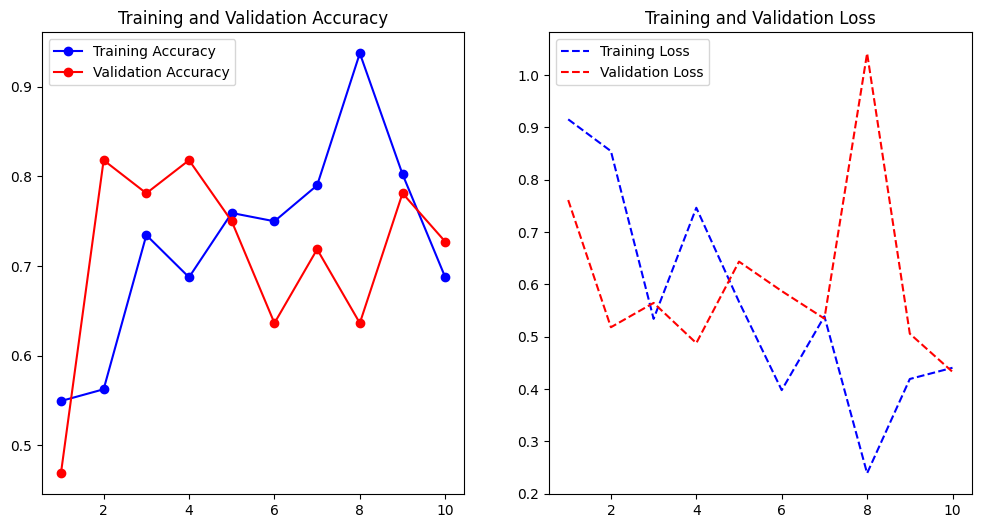

In [68]:
# Plot training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Predictions and Visualisation

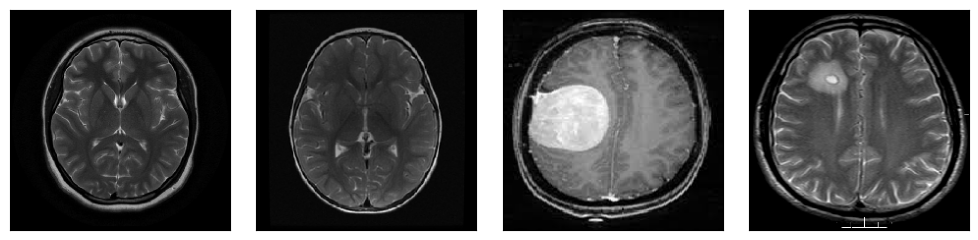

In [69]:
image_paths = [
    'brain_tumor_dataset/test/no/1 no.jpeg',
    'brain_tumor_dataset/test/no/2 no.jpeg',
    'brain_tumor_dataset/test/yes/Y1.jpg',
    'brain_tumor_dataset/test/yes/Y3.jpg'
]

# Load and process images
images = [load_img(path, target_size=(224, 224)) for path in image_paths]
images_array = np.array([img_to_array(img) for img in images])
processed_images = np.array([preprocess_input(img) for img in images_array])

# Display images
plt.figure(figsize=(10, 2.5))
for i, img in enumerate(images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

model_input = np.vstack([img.reshape(1, 224, 224, 3) for img in processed_images])


In [70]:
predictions = model.predict(model_input)

# Interpret the sigmoid output for binary classification
predicted_labels = ['yes' if pred > 0.5 else 'no' for pred in predictions.flatten()]

# Print predictions
for i, label in enumerate(predicted_labels):
    print(f"Prediction for Image {i + 1}: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Prediction for Image 1: no
Prediction for Image 2: no
Prediction for Image 3: yes
Prediction for Image 4: yes


In [79]:
# Adjustments to import necessary keras modules
import collections.abc
# Ensure that Iterable can be imported from collections directly
if not hasattr(collections, 'Iterable'):
    collections.Iterable = collections.abc.Iterable

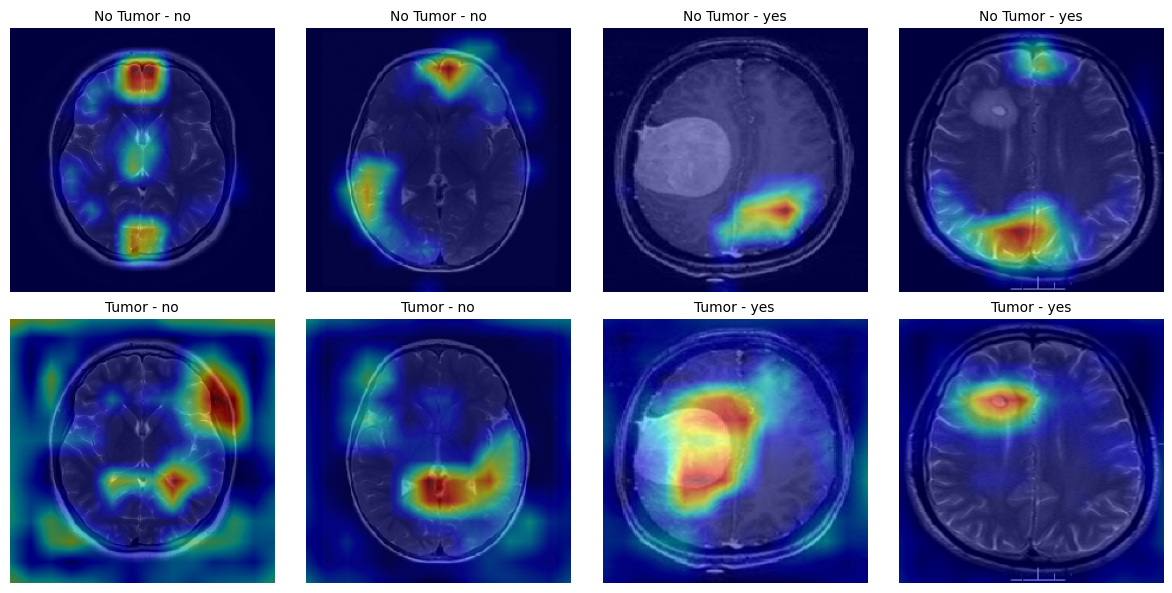

In [86]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore

# Assuming `processed_images` are already preprocessed
input_images = preprocess_input(processed_images)

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=ReplaceToLinear(),
                  clone=True)

# Input classes for binary classification
input_classes = ['No Tumor', 'Tumor']

# Set up figure for visualization
num_images = len(images)
fig, ax = plt.subplots(nrows=2, ncols=num_images, figsize=(12, 6))  # 2 rows for each class

for j, class_id in enumerate([0, 1]):  # 0 for 'No Tumor', 1 for 'Tumor'
    score = BinaryScore([class_id])
    cam = gradcam(score, input_images, penultimate_layer=-1)

    for i in range(num_images):
        # Generate heatmap
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[j, i].set_title(f"{input_classes[class_id]} - {predicted_labels[i]}", fontsize=10)
        ax[j, i].imshow(images[i])
        ax[j, i].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap
        ax[j, i].axis('off')

plt.tight_layout()
plt.show()


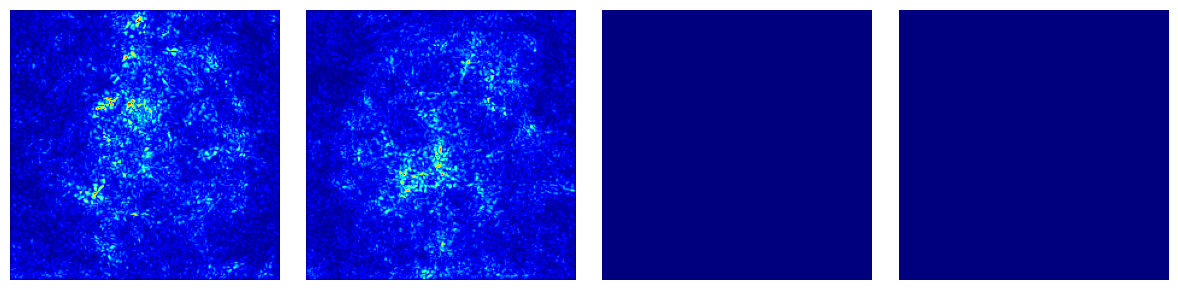

In [87]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is already loaded and 'input_images' are preprocessed properly
# Create Saliency object
saliency = Saliency(model, model_modifier=None, clone=False)

# Assuming '1' represents "Tumor" - adjust BinaryScore accordingly if needed
score = BinaryScore([0])  # Adjust index based on your class label needs

# Generate saliency map with smoothing
saliency_map = saliency(score, input_images, smooth_samples=20, smooth_noise=0.20)
saliency_map = normalize(saliency_map)

# Setup subplot
num_images = len(input_images)
fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 3, 3))
if num_images > 1:
    for i in range(num_images):
        ax[i].imshow(saliency_map[i], cmap='jet')
        ax[i].axis('off')
else:
    ax.imshow(saliency_map[0], cmap='jet')  # For single image case
    ax.axis('off')

plt.tight_layout()
plt.show()
